# ABU量化系统使用文档 

<center>
        <img src="./image/abu_logo.png" alt="" style="vertical-align:middle;padding:10px 20px;"><font size="6" color="black"><b>第8节 A股市场的回测</b></font>
</center>

-----------------

作者: 阿布

阿布量化版权所有 未经允许 禁止转载

[abu量化系统github地址](https://github.com/bbfamily/abu) (您的star是我的动力！)

[本节ipython notebook](https://github.com/bbfamily/abu/tree/master/abupy_lecture)

之前的小节回测示例都是使用美股，本节示例A股市场的回测。

首先导入abupy中本节使用的模块：

In [1]:
# 基础库导入

from __future__ import print_function
from __future__ import division

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import os
import sys
# 使用insert 0即只使用github，避免交叉使用了pip安装的abupy，导致的版本不一致问题
sys.path.insert(0, os.path.abspath('../'))
import abupy

# 使用沙盒数据，目的是和书中一样的数据环境
abupy.env.enable_example_env_ipython()

enable example env will only read RomDataBu/df_kl.h5


买入因子，卖出因子等依然使用相同的设置，如下所示：

In [2]:
from abupy import AbuFactorAtrNStop, AbuFactorPreAtrNStop, AbuFactorCloseAtrNStop, AbuFactorBuyBreak
from abupy import abu, EMarketTargetType, AbuMetricsBase, ABuMarketDrawing, ABuProgress, ABuSymbolPd

# 设置初始资金数
read_cash = 1000000

# 买入因子依然延用向上突破因子
buy_factors = [{'xd': 60, 'class': AbuFactorBuyBreak},
               {'xd': 42, 'class': AbuFactorBuyBreak}]

# 卖出因子继续使用上一节使用的因子
sell_factors = [
    {'stop_loss_n': 1.0, 'stop_win_n': 3.0,
     'class': AbuFactorAtrNStop},
    {'class': AbuFactorPreAtrNStop, 'pre_atr_n': 1.5},
    {'class': AbuFactorCloseAtrNStop, 'close_atr_n': 1.5}
]

### 1. A股市场的回测示例

择时股票池使用沙盒缓存数据中的如下股票：

#### A股市场：

* 科大讯飞(002230)
* 乐视网(300104)
* 东方财富(300059)
* 中国中车(601766)
* 同仁堂(600085),
* 招商银行(600036)
* 山西汾酒(600809)
* 万科A(000002)
* 比亚迪(002594)
* 万达电影(002739)
* 上证指数(sh000001)

代码如下所示：

In [3]:
# 择时股票池
choice_symbols = ['002230', '300104', '300059', '601766', '600085', '600036', '600809', '000002', '002594', '002739']

In [4]:
# 使用run_loop_back运行策略
abu_result_tuple, kl_pd_manger = abu.run_loop_back(read_cash,
                                                   buy_factors,
                                                   sell_factors,
                                                   n_folds=6,
                                                   choice_symbols=choice_symbols)
ABuProgress.clear_output()

买入后卖出的交易数量:169
买入后尚未卖出的交易数量:1
胜率:55.6213%
平均获利期望:17.4736%
平均亏损期望:-6.6848%
盈亏比:3.5702
策略收益: 164.6985%
基准收益: 75.7668%
策略年化收益: 41.1746%
基准年化收益: 18.9417%
策略买入成交比例:88.2353%
策略资金利用率比例:34.8566%
策略共执行1008个交易日


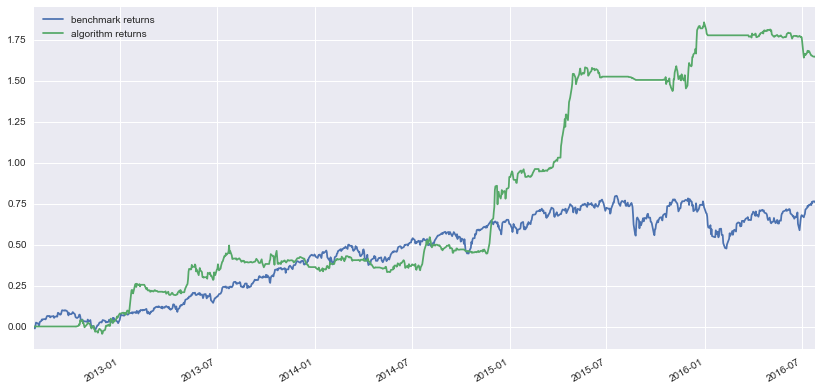

In [5]:
AbuMetricsBase.show_general(*abu_result_tuple, only_show_returns=True)

上面的回测结果虽然可以正常运行，但是很多交易细节还是使用的默认设置中的美股交易模式，因为默认的设置EMarketTargetType.E_MARKET_TARGET_US是美股，它会影响到一年多少个交易日等等交易细节，基准标尺等问题，如注意观察上面使用使用show_general显示的最终收益对比图，可以发现策略收益对比的是纳斯达克指数，并不是A股大盘。

正确的做法是首先将abupy量化环境设置为A股，代码如下所示：

In [6]:
abupy.env.g_market_target = EMarketTargetType.E_MARKET_TARGET_CN

In [7]:
abu_result_tuple, kl_pd_manger = abu.run_loop_back(read_cash,
                                                   buy_factors,
                                                   sell_factors,
                                                   n_folds=6,
                                                   choice_symbols=choice_symbols)
ABuProgress.clear_output()

买入后卖出的交易数量:252
买入后尚未卖出的交易数量:2
胜率:43.6508%
平均获利期望:17.5752%
平均亏损期望:-6.9084%
盈亏比:2.1424
策略收益: 114.8238%
基准收益: 20.6036%
策略年化收益: 19.8870%
基准年化收益: 3.5685%
策略买入成交比例:83.0709%
策略资金利用率比例:38.6073%
策略共执行1455个交易日


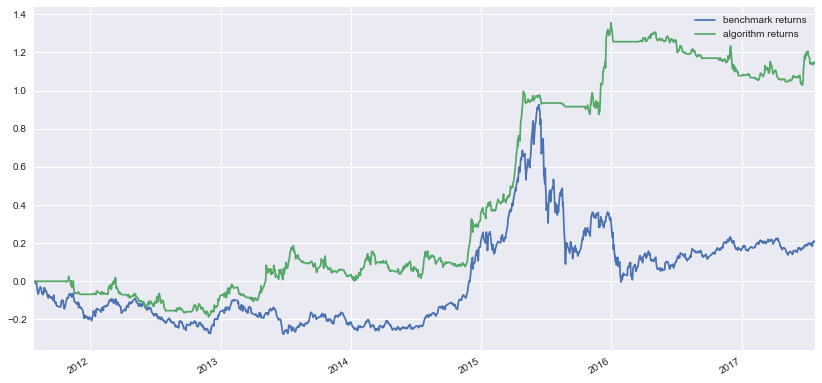

In [8]:
AbuMetricsBase.show_general(*abu_result_tuple, only_show_returns=True)

### 2. 涨跌停的特殊处理

下面主要讲解一下A股市场中比较特殊的地方：涨停，跌停，首先看一下下面这笔交易：

In [9]:
orders_pd = abu_result_tuple.orders_pd
view_orders = orders_pd[(orders_pd['symbol'] == '601766') & (orders_pd['buy_date'] == 20150417)]
view_orders

,buy_date,buy_price,buy_cnt,buy_factor,symbol,buy_pos,buy_type_str,expect_direction,sell_type_extra,sell_date,sell_price,sell_type,ml_features,key,profit,result,profit_cg,profit_cg_hunder,keep_days
2015-04-17,20150417,35.61,2400.0,AbuFactorBuyBreak:60,601766,AbuAtrPosition,call,1.0,AbuFactorAtrNStop:stop_loss=1.0,20150608,32.13,loss,None,900,-8352.0,-1,-0.0977,-9.7725,52


从交易单来看似乎一切ok，虽然最终交易亏损了，下面使用plot_candle_from_order可视化view_orders，plot_candle_from_order标记出了买入和卖出点

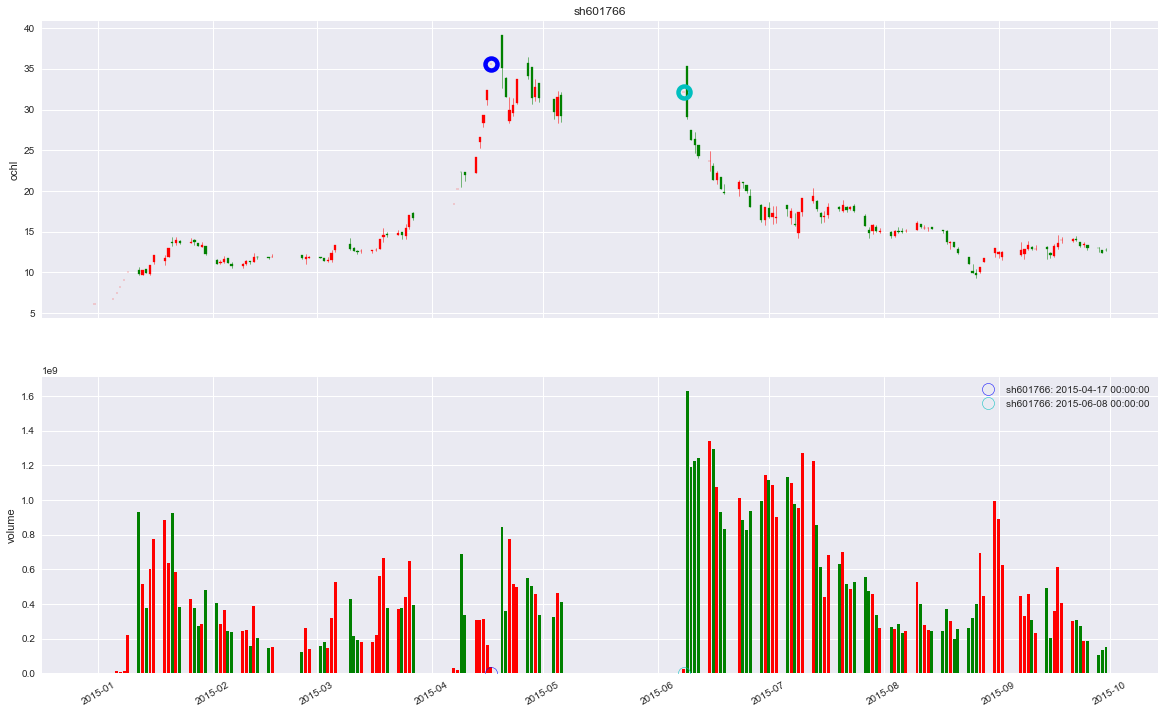

In [10]:
trade_df = ABuMarketDrawing.plot_candle_from_order(view_orders)

ABuMarketDrawing.plot_candle_from_order返回的trade_df是这笔交易的持股周期内的金融时间序列，如下所示，看第一条数据
2015-04-17交易日即为买入交易日，可以发现close，high，low的价格都是一样的，这代表了在集合竞价阶段股票已经涨停，但在我们回测中默认使用的
滑点买入类依然认为可以买入。

备注：滑点类相关内容请阅读：滑点策略与交易手续费

In [11]:
print('买入价格为：{}'.format(view_orders.iloc[0].buy_price))
trade_df.head()

买入出价格为：35.61


,close,high,low,p_change,open,pre_close,volume,date,date_week,key,atr21,atr14
2015-04-17,35.61,35.61,35.61,10.077,35.61,32.35,38949900,20150417,4,63,2.9390,3.5273
2015-04-20,35.11,39.20,32.61,-1.404,39.20,35.61,843953322,20150420,0,64,3.2953,3.9703
2015-04-21,31.57,34.00,31.57,-10.083,33.83,35.11,357461681,20150421,1,65,3.3631,3.9796
2015-04-22,29.99,31.57,28.39,-5.005,28.64,31.57,773508495,20150422,2,66,3.6688,4.3450
2015-04-23,30.60,31.41,29.23,2.034,29.53,29.99,513939670,20150423,3,67,3.5478,4.0777


和买入类似，注意下面这笔交易：

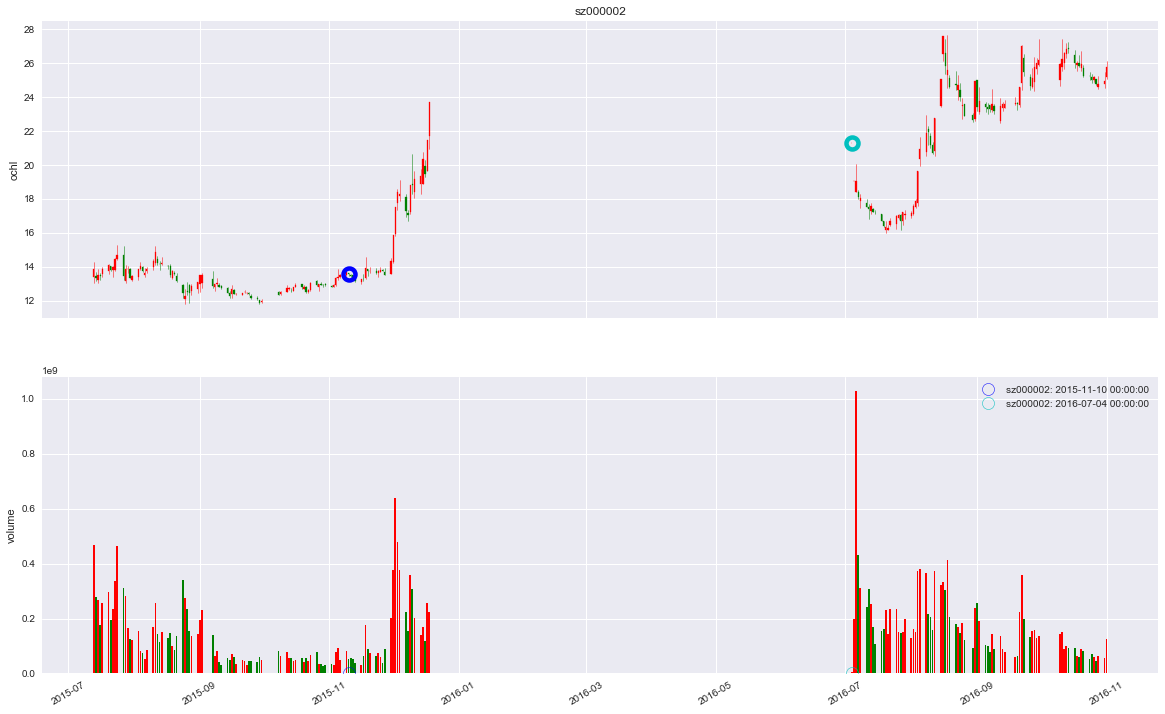

卖出价格为：21.27


,close,high,low,p_change,open,pre_close,volume,date,date_week,key,atr21,atr14
2015-12-15,20.36,20.74,18.88,5.165,18.88,19.36,167387632,20151215,1,104,1.4807,1.6874
2015-12-16,19.47,20.27,19.29,-4.371,19.91,20.36,118536396,20151216,2,105,1.4352,1.5931
2015-12-17,21.49,21.49,19.63,10.375,19.66,19.47,258339265,20151217,3,106,1.4738,1.6286
2015-12-18,23.71,23.71,20.94,10.330,21.68,21.49,223898402,20151218,4,107,1.7253,1.9768
2016-07-04,21.27,21.27,21.27,-10.291,21.27,23.71,4266300,20160704,0,108,1.5884,1.7426


In [13]:
view_orders = orders_pd[(orders_pd['symbol'] == '000002') & (orders_pd['sell_date'] == 20160704)]
trade_df = ABuMarketDrawing.plot_candle_from_order(view_orders.iloc[0])
print('卖出价格为：{}'.format(view_orders.iloc[0].sell_price))
trade_df.tail()

上面ABuMarketDrawing.plot_candle_from_order返回的trade_df是这笔交易的持股周期内的金融时间序列，看第最后一条数据
2016-07-04交易日即为卖出交易日，可以发现close，high，low的价格都是一样的，这代表了在集合竞价阶段股票已经跌停，但在我们回测中默认使用的
滑点卖出类依然认为可以卖出。

类似的情况还有下面这种虽然并不是在集合竞价阶段股票涨停，但是涨停下依然使用当天最高最低均价买入，买入价格为：1.175显然也不合适，同理在非集合竞价跌停的情况下以当天的平均价格卖出也不合适。

备注：默认滑点类使用均价买入卖出，详情阅读AbuSlippageSellBase，AbuSlippageBuyBase

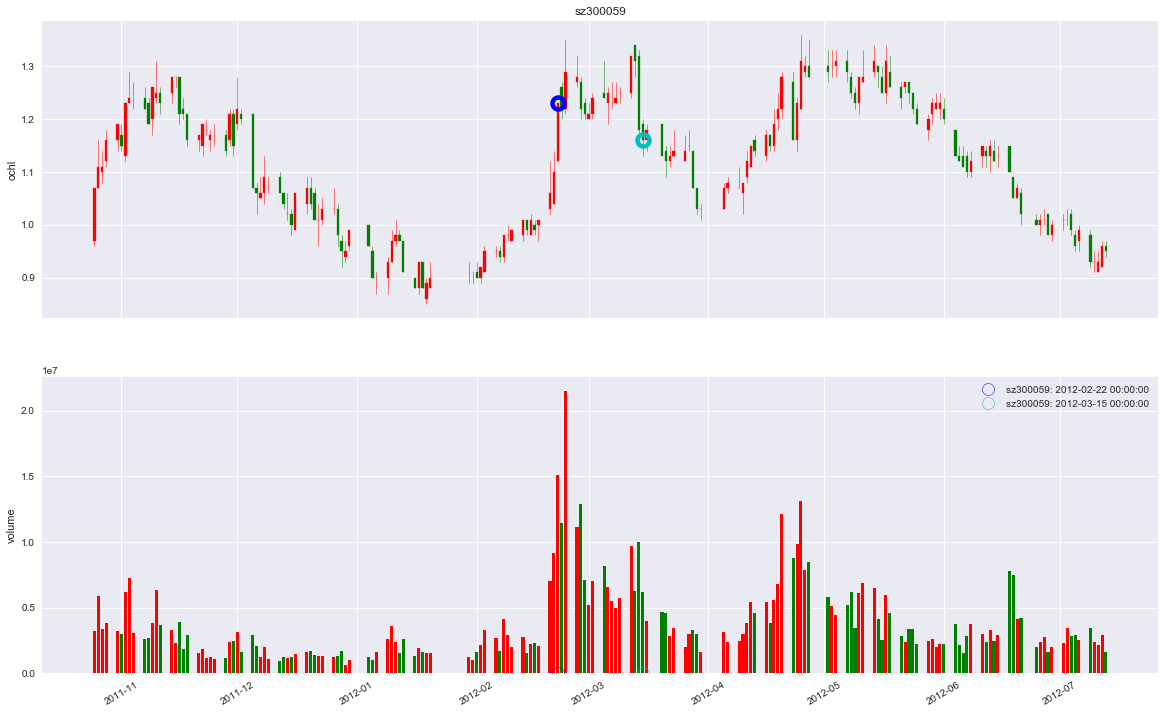

买入价格为：1.175


,close,high,low,p_change,open,pre_close,volume,date,date_week,key,atr21,atr14
2012-02-22,1.23,1.23,1.12,11.818,1.12,1.1,15130356,20120222,2,79,0.0693,0.0771


In [14]:
view_orders = orders_pd[(orders_pd['symbol'] == '300059') & (orders_pd['buy_date'] == 20120222)]
trade_df = ABuMarketDrawing.plot_candle_from_order(view_orders.iloc[0])
print('买入价格为：{}'.format(view_orders.iloc[0].buy_price))
trade_df.head(1)

为解决上述问题abupy中有针对A股涨停和跌停的特殊装饰器封装在滑点模块中：

具体实现原理不在这里展开，效果为：

1. 针对非集合竞价阶段的涨停，滑点买入价格以高概率在接近涨停的价格买入
2. 针对非集合竞价阶段的跌停，滑点卖出价格以高概率在接近跌停的价格卖出
3. 集合竞价阶段的涨停根据设置中的买入成功概率进行买入决策
3. 集合竞价阶段的跌停根据设置中的卖出成功概率进行卖出决策

具体实现请阅读源代码AbuSlippageSellBase，AbuSlippageBuyBase。

下面的代码即将上述4个针对A股涨停和跌停的特殊设置打开：

In [15]:
from abupy import slippage
# 开启针对非集合竞价阶段的涨停，滑点买入价格以高概率在接近涨停的价格买入
slippage.sbb.g_enable_limit_up = True
# 将集合竞价阶段的涨停买入成功概率设置为0，如果设置为0.2即20%概率成功买入
slippage.sbb.g_pre_limit_up_rate = 0
# 开启针对非集合竞价阶段的跌停，滑点卖出价格以高概率在接近跌停的价格卖出
slippage.ssb.g_enable_limit_down = True
# 将集合竞价阶段的跌停卖出成功概率设置为0, 如果设置为0.2即20%概率成功卖出
slippage.ssb.g_pre_limit_down_rate = 0

其它的回测因子等设置都不变，重新使用abu.run_loop_back进行回测，代码如下：

In [16]:
abu_result_slippage, kl_pd_manger = abu.run_loop_back(read_cash,
                                                   buy_factors,
                                                   sell_factors,
                                                   n_folds=6,
                                                   choice_symbols=choice_symbols)
ABuProgress.clear_output()

买入后卖出的交易数量:249
买入后尚未卖出的交易数量:2
胜率:42.9719%
平均获利期望:16.4189%
平均亏损期望:-6.8735%
盈亏比:1.8920
策略收益: 89.4554%
基准收益: 20.6036%
策略年化收益: 15.4933%
基准年化收益: 3.5685%
策略买入成交比例:82.4701%
策略资金利用率比例:39.7315%
策略共执行1455个交易日


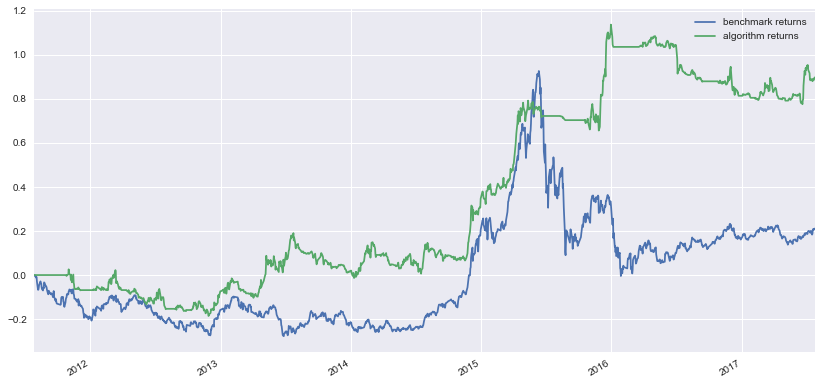

In [17]:
AbuMetricsBase.show_general(*abu_result_slippage, only_show_returns=True)

上面的度量显示买入后卖出的交易数量:249，之前没开启涨跌停时是252，即可知道有三笔交易由于开启了涨跌停没有进行买入，但是怎么能知道那些交易发生了变化呢?

备注：读者可尝试使用 ABU量化系统使用文档－第九节 港股市场的回测 中讲解的AbuSDBreak对上面A股交易进行回测，度量结果。

### 3. 对多组交易结果进行分析

AbuOrderPdProxy是abupy中内置的针对交易单对象进行并集，交集，差集等交易单分析使用的工具，通过EOrderSameRule使用不同的判断为是否相同使用的交易单规则，更多实现详情请阅读AbuOrderPdProxy源代码，下面示例使用:

In [18]:
from abupy import AbuOrderPdProxy, EOrderSameRule

orders_pd_slippage = abu_result_slippage.orders_pd
# 通过orders_pd构造AbuOrderPdProxy
proxy = AbuOrderPdProxy(orders_pd)
with proxy.proxy_work(abu_result_slippage.orders_pd) as (order, order_slippage):
    print('order == order_slippage: {}'.format(order == order_slippage))
    print('order > order_slippage: {}'.format(order > order_slippage))
    diff_a = order - order_slippage
    diff_b = order_slippage - order

order == order_slippage: False
order > order_slippage: True


下面对比一下两个差集的第一个数据，可以发现不同点是买入价格：

* 未使用涨跌停控制的diff_a的交易依然是使用1.17的价格买入股票
* 使用涨跌停控制的diff_b的交易使用接近涨停价格1.23的价格买入股票

备注：读者可以输出diff_a，diff_b自行一个一个对比一下看看，这里不再详对

In [19]:
diff_a.head(1)

,buy_date,buy_price,buy_cnt,buy_factor,symbol,buy_pos,buy_type_str,expect_direction,sell_type_extra,sell_date,sell_price,sell_type,ml_features,key,profit,result,profit_cg,profit_cg_hunder,keep_days,difference
2012-02-22,20120222,1.175,96100.0,AbuFactorBuyBreak:42,300059,AbuAtrPosition,call,1.0,AbuFactorPreAtrNStop:pre_atr=1.5,20120315,1.165,loss,None,136,-961.0,-1,-0.0085,-0.8511,22,True


In [20]:
diff_b.head(1)

,buy_date,buy_price,buy_cnt,buy_factor,symbol,buy_pos,buy_type_str,expect_direction,sell_type_extra,sell_date,sell_price,sell_type,ml_features,key,profit,result,profit_cg,profit_cg_hunder,keep_days,difference
2012-02-22,20120222,1.16,96100.0,AbuFactorBuyBreak:42,300059,AbuAtrPosition,call,1.0,AbuFactorPreAtrNStop:pre_atr=1.5,20120315,1.165,win,None,136,480.5,1,0.0043,0.431,22,True


下面通过EOrderSameRule.ORDER_SAME_BD做为AbuOrderPdProxy的参数，这样构造的AbuOrderPdProxy即切换了对交易单相同的规则：

    class EOrderSameRule(Enum):
        """对order_pd中对order判断为是否相同使用的规则"""

        """order有相同的symbol和买入日期就认为是相同"""
        ORDER_SAME_BD = 0
        """order有相同的symbol, 买入日期，和卖出日期，即不考虑价格，只要日期相同就相同"""
        ORDER_SAME_BSD = 1
        """order有相同的symbol, 买入日期，相同的买入价格，即单子买入时刻都相同"""
        ORDER_SAME_BDP = 2
        """order有相同的symbol, 买入日期, 买入价格, 并且相同的卖出日期和价格才认为是相同，即买入卖出时刻都相同"""
        ORDER_SAME_BSPD = 3

使用相同的symbol和买入日期就认为是相同的规则，结果如下：

In [21]:
proxy = AbuOrderPdProxy(orders_pd, EOrderSameRule.ORDER_SAME_BD)
with proxy.proxy_work(abu_result_slippage.orders_pd) as (order, order_slippage):
    diff_c = order - order_slippage
diff_c

,buy_date,buy_price,buy_cnt,buy_factor,symbol,buy_pos,buy_type_str,expect_direction,sell_type_extra,sell_date,sell_price,sell_type,ml_features,key,profit,result,profit_cg,profit_cg_hunder,keep_days,difference
2013-10-09,20131009,17.44,11400.0,AbuFactorBuyBreak:42,300104,AbuAtrPosition,call,1.0,AbuFactorCloseAtrNStop:close_atr_n=1.5,20131024,19.00,win,None,527,17784.0,1,0.0894,8.9450,15,True
2015-04-17,20150417,16.41,12100.0,AbuFactorBuyBreak:60,300059,AbuAtrPosition,call,1.0,AbuFactorAtrNStop:stop_win=3.0,20150430,37.55,win,None,900,255794.0,1,1.2882,128.8239,13,True
2015-04-17,20150417,35.61,2400.0,AbuFactorBuyBreak:60,601766,AbuAtrPosition,call,1.0,AbuFactorAtrNStop:stop_loss=1.0,20150608,32.13,loss,None,900,-8352.0,-1,-0.0977,-9.7725,52,True


In [22]:
ABuSymbolPd.make_kl_df('601766', start='20150417', end='20150417')

,close,high,low,p_change,open,pre_close,volume,date,date_week,key,atr21,atr14
2015-04-17,35.61,35.61,35.61,10.077,35.61,32.35,38949900,20150417,4,0,0,0


In [23]:
ABuSymbolPd.make_kl_df('300104', start='20131009', end='20131009')

,close,high,low,p_change,open,pre_close,volume,date,date_week,key,atr21,atr14
2013-10-09,17.44,17.44,17.44,10.032,17.44,15.85,485750,20131009,2,0,0,0


可以看到diff_c中展示的三个交易单都是在集合竞价阶段已涨停了的股票交易，在开启了涨跌停控制后这三笔交易都没有进行买入。

如上述使用的AbuOrderPdProxy等工具，abupy不仅仅提供了对交易进行回测的功能，有许多分析，统计，机器学习，以及可视化工具在项目中可以帮助你分析策略，分析回测结果，以及为产生新的策略产生基础阀值等功能，在之后的教程中将陆续讲解使用以及示例。

#### abu量化文档目录章节

1. [择时策略的开发](http://www.abuquant.com/lecture/lecture_1.html)
2. [择时策略的优化](http://www.abuquant.com/lecture/lecture_2.html)
3. [滑点策略与交易手续费](http://www.abuquant.com/lecture/lecture_3.html)
4. [多支股票择时回测与仓位管理](http://www.abuquant.com/lecture/lecture_4.html)
5. [选股策略的开发](http://www.abuquant.com/lecture/lecture_5.html)
6. [回测结果的度量](http://www.abuquant.com/lecture/lecture_6.html)
7. [寻找策略最优参数和评分](http://www.abuquant.com/lecture/lecture_7.html)
8. [A股市场的回测](http://www.abuquant.com/lecture/lecture_8.html)
9. [港股市场的回测](http://www.abuquant.com/lecture/lecture_9.html)
10. [比特币，莱特币的回测](http://www.abuquant.com/lecture/lecture_10.html)
11. [期货市场的回测](http://www.abuquant.com/lecture/lecture_11.html)
12. [机器学习与比特币示例](http://www.abuquant.com/lecture/lecture_12.html)
13. [量化技术分析应用](http://www.abuquant.com/lecture/lecture_13.html)
14. [量化相关性分析应用](http://www.abuquant.com/lecture/lecture_14.html)
15. [量化交易和搜索引擎](http://www.abuquant.com/lecture/lecture_15.html)
16. [UMP主裁交易决策](http://www.abuquant.com/lecture/lecture_16.html)
17. [UMP边裁交易决策](http://www.abuquant.com/lecture/lecture_17.html)
18. [自定义裁判决策交易](http://www.abuquant.com/lecture/lecture_18.html)
19. [数据源](http://www.abuquant.com/lecture/lecture_19.html)
20. [A股全市场回测](http://www.abuquant.com/lecture/lecture_20.html)
21. [A股UMP决策](http://www.abuquant.com/lecture/lecture_21.html)
22. [美股全市场回测](http://www.abuquant.com/lecture/lecture_22.html)
23. [美股UMP决策](http://www.abuquant.com/lecture/lecture_23.html)


abu量化系统文档教程持续更新中，请关注公众号中的更新提醒。

#### 《量化交易之路》目录章节及随书代码地址

1. [第二章 量化语言——Python](https://github.com/bbfamily/abu/tree/master/ipython/第二章-量化语言——Python.ipynb)
2. [第三章 量化工具——NumPy](https://github.com/bbfamily/abu/tree/master/ipython/第三章-量化工具——NumPy.ipynb)
3. [第四章 量化工具——pandas](https://github.com/bbfamily/abu/tree/master/ipython/第四章-量化工具——pandas.ipynb)
4. [第五章 量化工具——可视化](https://github.com/bbfamily/abu/tree/master/ipython/第五章-量化工具——可视化.ipynb)
5. [第六章 量化工具——数学：你一生的追求到底能带来多少幸福](https://github.com/bbfamily/abu/tree/master/ipython/第六章-量化工具——数学.ipynb)
6. [第七章 量化系统——入门：三只小猪股票投资的故事](https://github.com/bbfamily/abu/tree/master/ipython/第七章-量化系统——入门.ipynb)
7. [第八章 量化系统——开发](https://github.com/bbfamily/abu/tree/master/ipython/第八章-量化系统——开发.ipynb)
8. [第九章 量化系统——度量与优化](https://github.com/bbfamily/abu/tree/master/ipython/第九章-量化系统——度量与优化.ipynb)
9. [第十章 量化系统——机器学习•猪老三](https://github.com/bbfamily/abu/tree/master/ipython/第十章-量化系统——机器学习•猪老三.ipynb)
10. [第十一章 量化系统——机器学习•ABU](https://github.com/bbfamily/abu/tree/master/ipython/第十一章-量化系统——机器学习•ABU.ipynb)
11. [附录A 量化环境部署](https://github.com/bbfamily/abu/tree/master/ipython/附录A-量化环境部署.ipynb)
12. [附录B 量化相关性分析](https://github.com/bbfamily/abu/tree/master/ipython/附录B-量化相关性分析.ipynb)
13. [附录C 量化统计分析及指标应用](https://github.com/bbfamily/abu/tree/master/ipython/附录C-量化统计分析及指标应用.ipynb)

[更多阿布量化量化技术文章](http://www.abuquant.com/article)

更多关于量化交易相关请阅读[《量化交易之路》](http://www.abuquant.com/books/quantify-trading-road.html)

更多关于量化交易与机器学习相关请阅读[《机器学习之路》](http://www.abuquant.com/books/machine-learning-road.html)

更多关于abu量化系统请关注微信公众号: abu_quant

如有任何问题也可在公众号中联系我的个人微信号。

![](./image/qrcode.jpg)